In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install git+https://github.com/benman1/time-series.git

  Cloning https://github.com/benman1/time-series.git to /tmp/pip-req-build-6s4yxv1c
  Running command git clone -q https://github.com/benman1/time-series.git /tmp/pip-req-build-6s4yxv1c


In [3]:
N_EPOCHS = 1

* Use TensorFlow graph models, which depend on non-eager execution.
* Set up output of intermediates to avoid a TensorFlow problem: Connecting to invalid output X of source node Y which has Z outputs.

In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
import tensorflow as tf

disable_eager_execution()  # for graph mode
tf.compat.v1.experimental.output_all_intermediates(True)

* Load the dataset using a utility method in the library and wrap it in a
TrainingDataSet class.

In [5]:
from time_series.dataset.utils import get_energy_demand
from time_series.dataset.time_series import TrainingDataSet

train_df = get_energy_demand()
tds = TrainingDataSet(train_df)

* Set up metrics and plotting methods that use for all the produced forecasts.

In [6]:
from time_series.utils import evaluate_model

* Go through the different forecasting methods in turn, DeepAR first.
* See the summary of the model and then the training error over time.

In [7]:
from time_series.models.deepar import DeepAR

ar_model = DeepAR(tds)
ar_model.instantiate_and_fit(verbose=1, epochs=N_EPOCHS)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 10)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 4)             240       
                                                                 
 dense (Dense)               (None, 10, 4)             20        
                                                                 
 main_output (GaussianLayer)  [(None, 10, 10),         100       
                              (None, 10, 10)]                    
                                                                 
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________
Train on 99336 samples
99336/99336 [==============================] - 17s 166us/sample - loss: 1.2933 - mean_absolute_percentage_

* This model is relatively simple, as we can see: only 360 parameters. 
* Obviously, we could tweak these parameters and add more.

* Produce predictions on the test dataset.
* See the errors – first the overall error and then for each of the 10 dimensions.
* See the plot over the first 10 time-steps.

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


MSE: 0.6988
----------
CT: 3.26
MASS: 4.2
ME: 2.5
NEMASSBOST: 4.69
NH: 5.41
RI: 3.08
SEMASS: 3.74
TOTAL: 3.86
VT: 2.51
WCMASS: 3.71


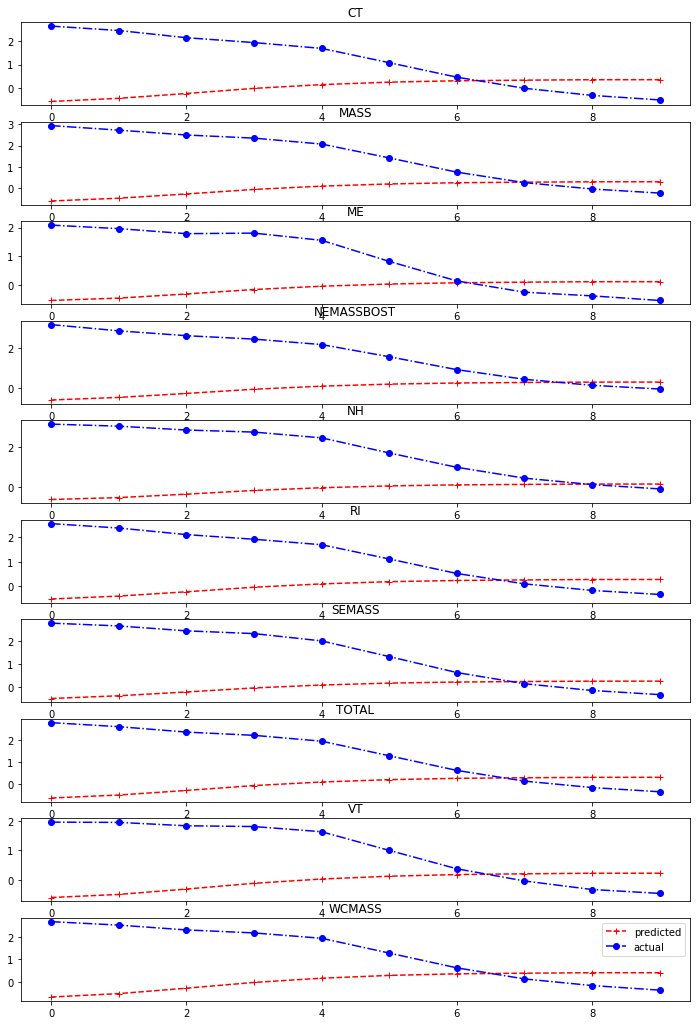

In [8]:
y_predicted = ar_model.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)

* Move on to the next method: N-BEATS.
* N-BEATS trains two networks. The forward network has 1,217,024 parameters.

In [9]:
from time_series.models.nbeats import NBeatsNet

nb = NBeatsNet(tds)
nb.instantiate_and_fit(verbose=1, epochs=N_EPOCHS)
#y_predicted = nb.model.predict(tds.X_test, steps=10)
#evaluate_model(first_n=10)
print(nb.model.evaluate(tds.X_test, tds.y_test))

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 10, 10)]     0           []                               
                                                                                                  
 lambda (Lambda)                (None, 10)           0           ['input_variable[0][0]']         
                                                                                                  
 lambda_1 (Lambda)              (None, 10)           0           ['input_variable[0][0]']         
                                                                                                  
 lambda_2 (Lambda)              (None, 10)           0           ['input_variable[0][0]']         
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


0.23376362051008212


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


MSE: 0.1165
----------
CT: 0.26
MASS: 0.26
ME: 0.1
NEMASSBOST: 0.25
NH: 0.37
RI: 0.06
SEMASS: 0.27
TOTAL: 0.21
VT: 0.4
WCMASS: 0.3


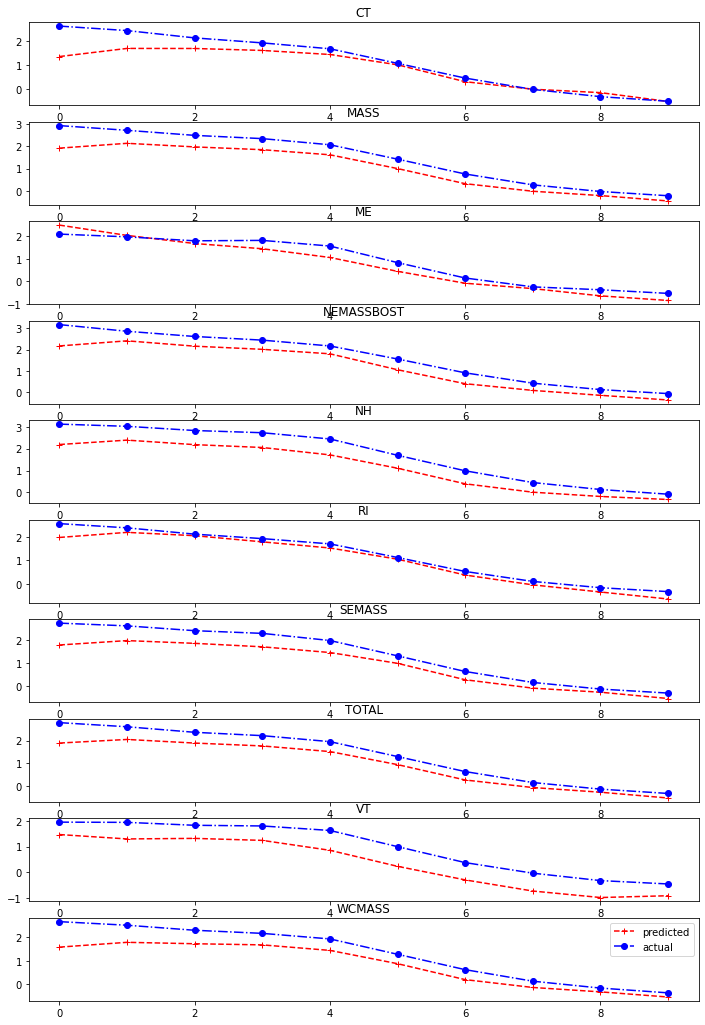

In [10]:
y_predicted = nb.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)

* LSTM is next.
* This model takes a lot more parameters than DeepAR.
* 45,000 parameters – this means this takes much longer to train than DeepAR.

In [11]:
from time_series.models.LSTM import LSTM
lstm = LSTM(tds)
lstm.instantiate_and_fit(verbose=1, epochs=1000)
#y_predicted = lstm.model.predict(tds.X_test, steps=10)
#evaluate_model(first_n=10)
print(lstm.model.evaluate(tds.X_test, tds.y_test))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           44400     
                                                                 
 dense_1 (Dense)             (None, 10, 10)            1010      
                                                                 
Total params: 45,410
Trainable params: 45,410
Non-trainable params: 0
_________________________________________________________________
None
Train on 99336 samples
Epoch 1/1000
99336/99336 [==============================] - 31s 314us/sample - loss: 0.3679 - mean_absolute_percentage_error: 299.4691 - mae: 0.4362 - mse: 0.3679
Epoch 2/1000
99336/99336 [==============================] - 31s 312us/sample - loss: 0.2311 - mean_absolute_percentage_error: 26

KeyboardInterrupt: ignored

In [ ]:
y_predicted = lstm.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)

In [ ]:
#tds_1step = TrainingDataSet(train_df, lag=tds.lag, two_dim=False)
#tds_1step.y_test = tds_1step.y_test[:, :, 0]
#tds_1step.y_train = tds_1step.y_train[:, :, 0]

* Let's do the transformer.

In [ ]:
# only training a 1-step prediction here:
from time_series.models.transformer import Transformer

trans = Transformer(tds)
trans.instantiate_and_fit(verbose=1, epochs=N_EPOCHS)
print(trans.model.evaluate(tds.X_test, tds.y_test))

* This model takes very long to train and the performance was the worst of the bunch.

In [ ]:
y_predicted = trans.model.predict(tds.X_test)  # .reshape(-1, 10)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)

* Last deep learning model is the TCN.

In [ ]:
from time_series.models.TCN import TCNModel

tcn_model = TCNModel(tds)
tcn_model.instantiate_and_fit(verbose=1, epochs=N_EPOCHS)
print(tcn_model.model.evaluate(tds.X_test, tds.y_test))

In [ ]:
y_predicted = tcn_model.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)